# Task 3: A/B Hypothesis Testing

**Project**: AlphaCare Insurance Solutions - Risk Analytics  
**Objective**: Statistically validate or reject key hypotheses about risk drivers

---

## Null Hypotheses

| # | Hypothesis | Test |
|---|------------|------|
| H₀₁ | No significant difference in charges across **regions** | One-way ANOVA |
| H₀₂ | No significant difference in charges between **Men and Women** | t-test |
| H₀₃ | No significant difference in charges between **Smokers and Non-smokers** | t-test |
| H₀₄ | No significant difference in charges across **BMI categories** | One-way ANOVA |

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Load data
df = pd.read_csv('../data/insurance.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (1338, 7)

Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Create BMI categories for segmentation
df['bmi_category'] = pd.cut(
    df['bmi'], 
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# Display data overview
print("Data Summary:")
print(f"- Total Records: {len(df)}")
print(f"- Regions: {df['region'].unique()}")
print(f"- Gender: {df['sex'].unique()}")
print(f"- Smoker Status: {df['smoker'].unique()}")
print(f"- BMI Categories: {df['bmi_category'].unique().tolist()}")

Data Summary:
- Total Records: 1338
- Regions: ['southwest' 'southeast' 'northwest' 'northeast']
- Gender: ['female' 'male']
- Smoker Status: ['yes' 'no']
- BMI Categories: ['Overweight', 'Obese', 'Normal', 'Underweight']


## 2. KPI Definition

**Primary KPI**: Insurance Charges (`charges`)
- This represents the cost/risk associated with each policyholder
- Higher charges indicate higher risk profiles

KPI: Insurance Charges
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


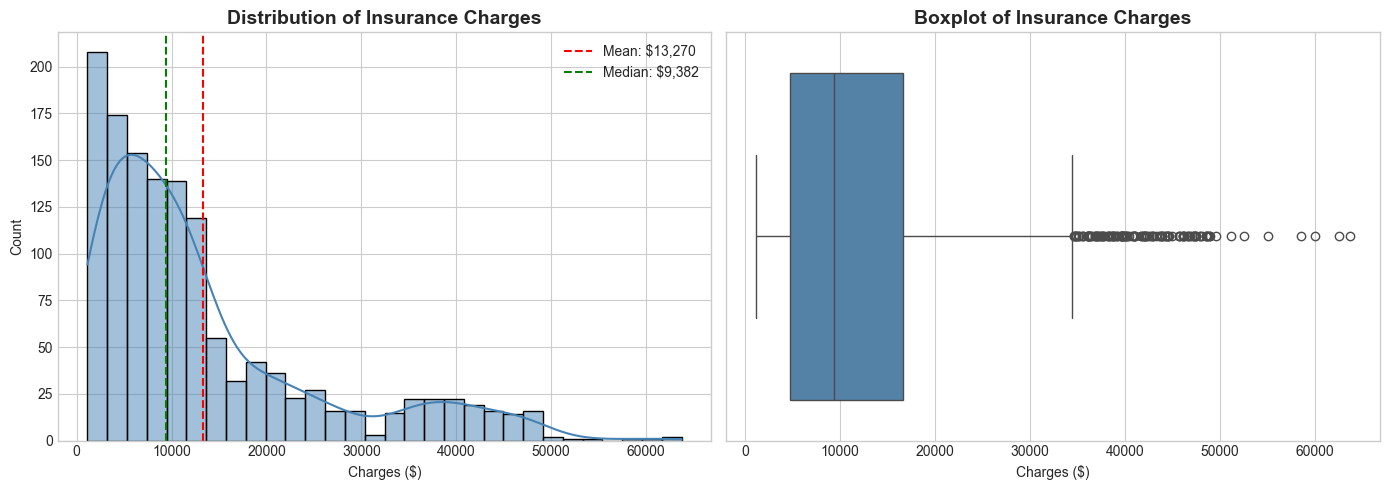

In [3]:
# KPI Overview
print("KPI: Insurance Charges")
print("="*40)
print(df['charges'].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
sns.histplot(df['charges'], kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Insurance Charges', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Charges ($)')
axes[0].axvline(df['charges'].mean(), color='red', linestyle='--', label=f"Mean: ${df['charges'].mean():,.0f}")
axes[0].axvline(df['charges'].median(), color='green', linestyle='--', label=f"Median: ${df['charges'].median():,.0f}")
axes[0].legend()

# Boxplot
sns.boxplot(x=df['charges'], ax=axes[1], color='steelblue')
axes[1].set_title('Boxplot of Insurance Charges', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Charges ($)')

plt.tight_layout()
plt.savefig('../reports/figures/kpi_charges_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 3. Hypothesis Testing

**Significance Level (α)**: 0.05

**Decision Rule**:
- If p-value < 0.05: **Reject H₀** (significant difference exists)
- If p-value ≥ 0.05: **Fail to reject H₀** (no significant difference)

### 3.1 H₀₁: No Risk Differences Across Regions

**Test**: One-way ANOVA (comparing 4 regions)

In [4]:
# Data Segmentation by Region
regions = df['region'].unique()
region_groups = {r: df[df['region'] == r]['charges'] for r in regions}

# Display group statistics
region_stats = df.groupby('region')['charges'].agg(['count', 'mean', 'std', 'median'])
region_stats.columns = ['Count', 'Mean', 'Std Dev', 'Median']
print("Regional Charge Statistics:")
print(region_stats.round(2))

Regional Charge Statistics:
           Count      Mean   Std Dev    Median
region                                        
northeast    324  13406.38  11255.80  10057.65
northwest    325  12417.58  11072.28   8965.80
southeast    364  14735.41  13971.10   9294.13
southwest    325  12346.94  11557.18   8798.59


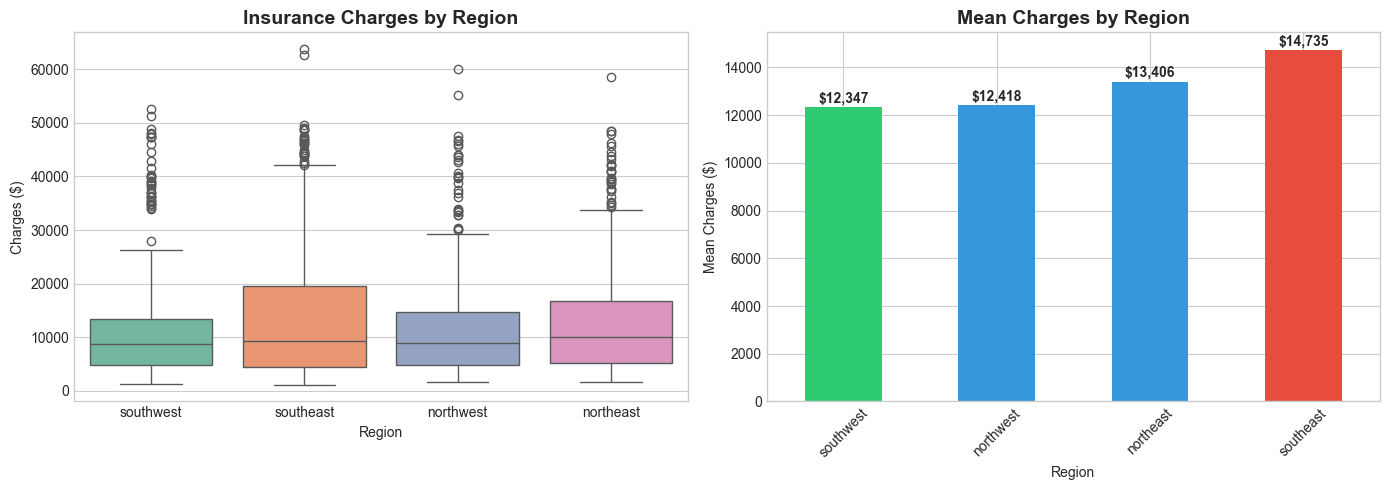

In [5]:
# Visualization: Regional Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='region', y='charges', ax=axes[0], palette='Set2')
axes[0].set_title('Insurance Charges by Region', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Charges ($)')

# Mean comparison bar
region_means = df.groupby('region')['charges'].mean().sort_values()
colors = ['#2ecc71' if v == region_means.min() else '#e74c3c' if v == region_means.max() else '#3498db' for v in region_means]
region_means.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Mean Charges by Region', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Mean Charges ($)')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(region_means):
    axes[1].text(i, v + 200, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/h1_regional_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Statistical Test: One-way ANOVA
f_stat, p_value = stats.f_oneway(
    region_groups['northeast'],
    region_groups['northwest'],
    region_groups['southeast'],
    region_groups['southwest']
)

print("="*60)
print("H₀₁: No significant difference in charges across regions")
print("="*60)
print(f"Test: One-way ANOVA")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nDecision (α=0.05): {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}")

if p_value < 0.05:
    print(f"\n✅ CONCLUSION: There ARE significant differences in charges across regions.")
else:
    print(f"\n❌ CONCLUSION: There are NO significant differences in charges across regions.")

H₀₁: No significant difference in charges across regions
Test: One-way ANOVA
F-statistic: 2.9696
P-value: 0.0309

Decision (α=0.05): REJECT H₀

✅ CONCLUSION: There ARE significant differences in charges across regions.


### 3.2 H₀₂: No Risk Differences Between Men and Women

**Test**: Independent t-test (comparing 2 groups)

In [7]:
# Data Segmentation by Gender
male_charges = df[df['sex'] == 'male']['charges']
female_charges = df[df['sex'] == 'female']['charges']

# Display group statistics
gender_stats = df.groupby('sex')['charges'].agg(['count', 'mean', 'std', 'median'])
gender_stats.columns = ['Count', 'Mean', 'Std Dev', 'Median']
print("Gender-based Charge Statistics:")
print(gender_stats.round(2))

Gender-based Charge Statistics:
        Count      Mean   Std Dev   Median
sex                                       
female    662  12569.58  11128.70  9412.96
male      676  13956.75  12971.03  9369.62


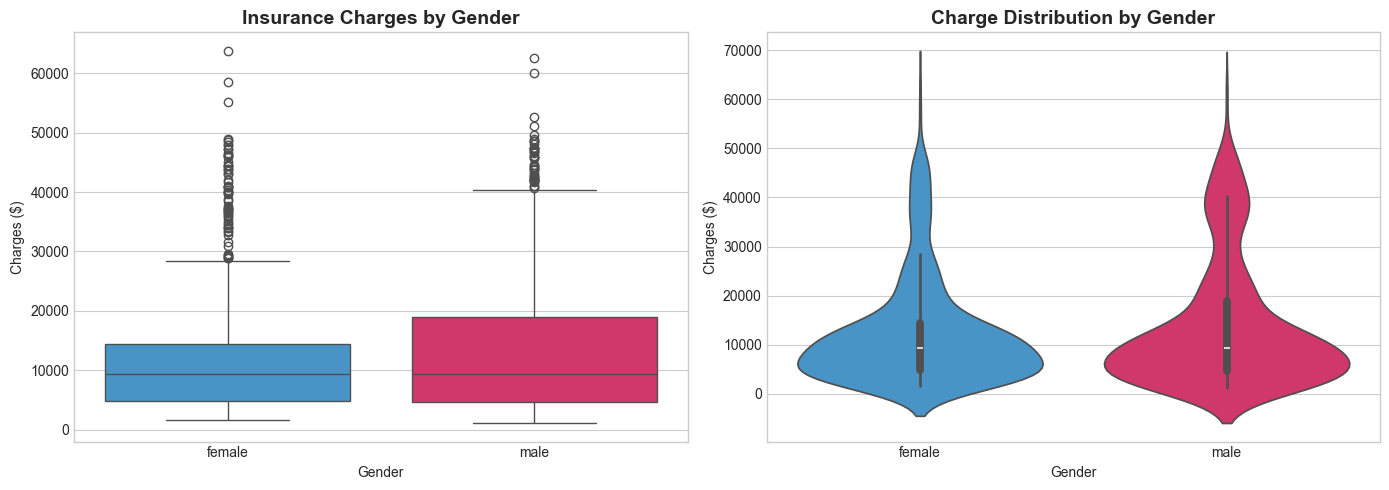

In [8]:
# Visualization: Gender Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='sex', y='charges', ax=axes[0], palette=['#3498db', '#e91e63'])
axes[0].set_title('Insurance Charges by Gender', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Charges ($)')

# Violin plot
sns.violinplot(data=df, x='sex', y='charges', ax=axes[1], palette=['#3498db', '#e91e63'])
axes[1].set_title('Charge Distribution by Gender', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Charges ($)')

plt.tight_layout()
plt.savefig('../reports/figures/h2_gender_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Statistical Test: Independent t-test
t_stat, p_value = stats.ttest_ind(male_charges, female_charges)

# Effect size (Cohen's d)
pooled_std = np.sqrt((male_charges.std()**2 + female_charges.std()**2) / 2)
cohens_d = (male_charges.mean() - female_charges.mean()) / pooled_std

print("="*60)
print("H₀₂: No significant risk difference between Women and Men")
print("="*60)
print(f"Test: Independent t-test")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Effect Size (Cohen's d): {cohens_d:.4f}")
print(f"\nMale Mean: ${male_charges.mean():,.2f}")
print(f"Female Mean: ${female_charges.mean():,.2f}")
print(f"Difference: ${male_charges.mean() - female_charges.mean():,.2f}")
print(f"\nDecision (α=0.05): {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}")

if p_value < 0.05:
    print(f"\n✅ CONCLUSION: There ARE significant differences in charges between genders.")
else:
    print(f"\n❌ CONCLUSION: There are NO significant differences in charges between genders.")

H₀₂: No significant risk difference between Women and Men
Test: Independent t-test
T-statistic: 2.0975
P-value: 0.0361
Effect Size (Cohen's d): 0.1148

Male Mean: $13,956.75
Female Mean: $12,569.58
Difference: $1,387.17

Decision (α=0.05): REJECT H₀

✅ CONCLUSION: There ARE significant differences in charges between genders.


### 3.3 H₀₃: No Risk Differences Between Smokers and Non-Smokers

**Test**: Independent t-test (comparing 2 groups)

In [10]:
# Data Segmentation by Smoker Status
smoker_charges = df[df['smoker'] == 'yes']['charges']
non_smoker_charges = df[df['smoker'] == 'no']['charges']

# Display group statistics
smoker_stats = df.groupby('smoker')['charges'].agg(['count', 'mean', 'std', 'median'])
smoker_stats.columns = ['Count', 'Mean', 'Std Dev', 'Median']
print("Smoker Status Charge Statistics:")
print(smoker_stats.round(2))

Smoker Status Charge Statistics:
        Count      Mean   Std Dev    Median
smoker                                     
no       1064   8434.27   5993.78   7345.41
yes       274  32050.23  11541.55  34456.35


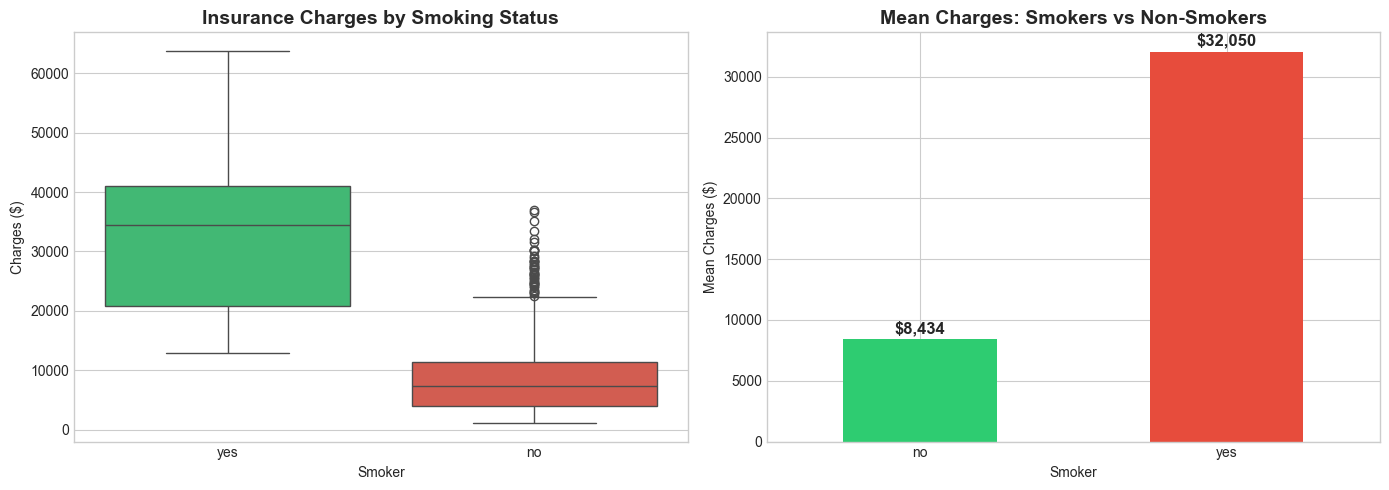

In [11]:
# Visualization: Smoker Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='smoker', y='charges', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Insurance Charges by Smoking Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Smoker')
axes[0].set_ylabel('Charges ($)')

# Bar chart with mean
smoker_means = df.groupby('smoker')['charges'].mean()
colors = ['#2ecc71', '#e74c3c']
smoker_means.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Mean Charges: Smokers vs Non-Smokers', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Smoker')
axes[1].set_ylabel('Mean Charges ($)')
axes[1].tick_params(axis='x', rotation=0)

# Add value labels
for i, v in enumerate(smoker_means):
    axes[1].text(i, v + 500, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/h3_smoker_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Statistical Test: Independent t-test
t_stat, p_value = stats.ttest_ind(smoker_charges, non_smoker_charges)

# Effect size (Cohen's d)
pooled_std = np.sqrt((smoker_charges.std()**2 + non_smoker_charges.std()**2) / 2)
cohens_d = (smoker_charges.mean() - non_smoker_charges.mean()) / pooled_std

print("="*60)
print("H₀₃: No significant risk difference between Smokers and Non-Smokers")
print("="*60)
print(f"Test: Independent t-test")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6e}")
print(f"Effect Size (Cohen's d): {cohens_d:.4f}")
print(f"\nSmoker Mean: ${smoker_charges.mean():,.2f}")
print(f"Non-Smoker Mean: ${non_smoker_charges.mean():,.2f}")
print(f"Difference: ${smoker_charges.mean() - non_smoker_charges.mean():,.2f}")
print(f"Premium Multiplier: {smoker_charges.mean() / non_smoker_charges.mean():.2f}x")
print(f"\nDecision (α=0.05): {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}")

if p_value < 0.05:
    print(f"\n✅ CONCLUSION: There ARE significant differences between smokers and non-smokers.")
    print(f"   Smokers pay approximately {smoker_charges.mean() / non_smoker_charges.mean():.1f}x more than non-smokers!")

H₀₃: No significant risk difference between Smokers and Non-Smokers
Test: Independent t-test
T-statistic: 46.6649
P-value: 8.271436e-283
Effect Size (Cohen's d): 2.5681

Smoker Mean: $32,050.23
Non-Smoker Mean: $8,434.27
Difference: $23,615.96
Premium Multiplier: 3.80x

Decision (α=0.05): REJECT H₀

✅ CONCLUSION: There ARE significant differences between smokers and non-smokers.
   Smokers pay approximately 3.8x more than non-smokers!


### 3.4 H₀₄: No Risk Differences Across BMI Categories

**Test**: One-way ANOVA (comparing 4 BMI categories)

In [13]:
# Data Segmentation by BMI Category
bmi_groups = {c: df[df['bmi_category'] == c]['charges'] for c in df['bmi_category'].dropna().unique()}

# Display group statistics
bmi_stats = df.groupby('bmi_category')['charges'].agg(['count', 'mean', 'std', 'median'])
bmi_stats.columns = ['Count', 'Mean', 'Std Dev', 'Median']
print("BMI Category Charge Statistics:")
print(bmi_stats.round(2))

BMI Category Charge Statistics:
              Count      Mean   Std Dev   Median
bmi_category                                    
Underweight      21   8657.62   7591.73  6640.54
Normal          226  10435.44   7484.43  8604.15
Overweight      386  10997.80   8067.25  8659.38
Obese           705  15560.93  14563.06  9964.06


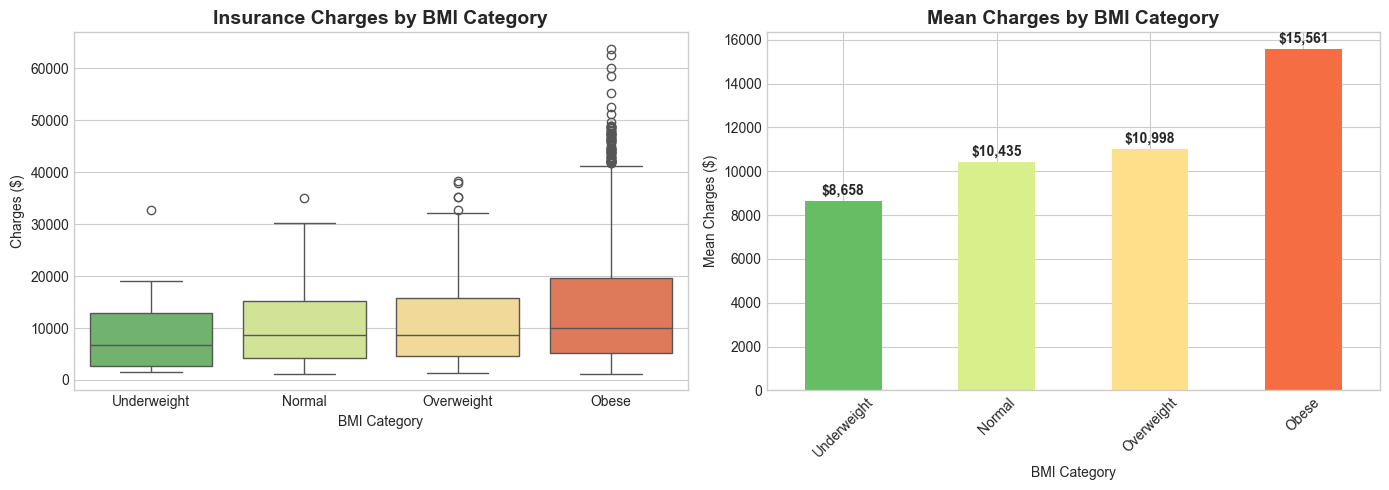

In [14]:
# Visualization: BMI Category Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
order = ['Underweight', 'Normal', 'Overweight', 'Obese']
sns.boxplot(data=df, x='bmi_category', y='charges', ax=axes[0], order=order, palette='RdYlGn_r')
axes[0].set_title('Insurance Charges by BMI Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('BMI Category')
axes[0].set_ylabel('Charges ($)')

# Mean comparison
bmi_means = df.groupby('bmi_category')['charges'].mean().reindex(order)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 4))
bmi_means.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Mean Charges by BMI Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('BMI Category')
axes[1].set_ylabel('Mean Charges ($)')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(bmi_means):
    axes[1].text(i, v + 300, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/h4_bmi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Statistical Test: One-way ANOVA
f_stat, p_value = stats.f_oneway(
    df[df['bmi_category'] == 'Underweight']['charges'],
    df[df['bmi_category'] == 'Normal']['charges'],
    df[df['bmi_category'] == 'Overweight']['charges'],
    df[df['bmi_category'] == 'Obese']['charges']
)

print("="*60)
print("H₀₄: No significant difference in charges across BMI categories")
print("="*60)
print(f"Test: One-way ANOVA")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6e}")
print(f"\nDecision (α=0.05): {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}")

if p_value < 0.05:
    print(f"\n✅ CONCLUSION: There ARE significant differences in charges across BMI categories.")

H₀₄: No significant difference in charges across BMI categories
Test: One-way ANOVA
F-statistic: 18.8050
P-value: 5.997613e-12

Decision (α=0.05): REJECT H₀

✅ CONCLUSION: There ARE significant differences in charges across BMI categories.


---

## 4. Summary of Results

In [16]:
# Create summary table
results = {
    'Hypothesis': [
        'H₀₁: No regional differences',
        'H₀₂: No gender differences', 
        'H₀₃: No smoker differences',
        'H₀₄: No BMI category differences'
    ],
    'Test': ['ANOVA', 't-test', 't-test', 'ANOVA'],
    'P-value': [],
    'Decision': [],
    'Significant': []
}

# H1: Regional
_, p1 = stats.f_oneway(*[df[df['region'] == r]['charges'] for r in df['region'].unique()])
results['P-value'].append(f"{p1:.4f}")
results['Decision'].append('Reject H₀' if p1 < 0.05 else 'Fail to Reject')
results['Significant'].append('Yes ✅' if p1 < 0.05 else 'No ❌')

# H2: Gender
_, p2 = stats.ttest_ind(df[df['sex']=='male']['charges'], df[df['sex']=='female']['charges'])
results['P-value'].append(f"{p2:.4f}")
results['Decision'].append('Reject H₀' if p2 < 0.05 else 'Fail to Reject')
results['Significant'].append('Yes ✅' if p2 < 0.05 else 'No ❌')

# H3: Smoker
_, p3 = stats.ttest_ind(df[df['smoker']=='yes']['charges'], df[df['smoker']=='no']['charges'])
results['P-value'].append(f"{p3:.2e}")
results['Decision'].append('Reject H₀' if p3 < 0.05 else 'Fail to Reject')
results['Significant'].append('Yes ✅' if p3 < 0.05 else 'No ❌')

# H4: BMI
_, p4 = stats.f_oneway(*[df[df['bmi_category'] == c]['charges'] for c in df['bmi_category'].dropna().unique()])
results['P-value'].append(f"{p4:.2e}")
results['Decision'].append('Reject H₀' if p4 < 0.05 else 'Fail to Reject')
results['Significant'].append('Yes ✅' if p4 < 0.05 else 'No ❌')

summary_df = pd.DataFrame(results)
print("\n" + "="*80)
print("                    HYPOTHESIS TESTING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))


                    HYPOTHESIS TESTING SUMMARY
                      Hypothesis   Test   P-value  Decision Significant
    H₀₁: No regional differences  ANOVA    0.0309 Reject H₀       Yes ✅
      H₀₂: No gender differences t-test    0.0361 Reject H₀       Yes ✅
      H₀₃: No smoker differences t-test 8.27e-283 Reject H₀       Yes ✅
H₀₄: No BMI category differences  ANOVA  6.00e-12 Reject H₀       Yes ✅


---

## 5. Business Recommendations

In [17]:
print("\n" + "="*80)
print("                    BUSINESS RECOMMENDATIONS")
print("="*80)

recommendations = []

# Smoker recommendation (most impactful)
smoker_multiplier = df[df['smoker']=='yes']['charges'].mean() / df[df['smoker']=='no']['charges'].mean()
recommendations.append(f"""
🚬 SMOKING STATUS (Highest Impact)
   - Smokers pay {smoker_multiplier:.1f}x higher premiums than non-smokers
   - Recommendation: Implement tiered premium structure based on smoking status
   - Consider smoking cessation program incentives for premium discounts
""")

# BMI recommendation
obese_mean = df[df['bmi_category']=='Obese']['charges'].mean()
normal_mean = df[df['bmi_category']=='Normal']['charges'].mean()
recommendations.append(f"""
⚖️ BMI CATEGORIES (Significant Impact)
   - Obese customers: ${obese_mean:,.0f} avg vs Normal: ${normal_mean:,.0f} avg
   - Recommendation: Consider BMI-based risk assessment in underwriting
   - Wellness program incentives for weight management
""")

# Regional recommendation
if p1 < 0.05:
    max_region = df.groupby('region')['charges'].mean().idxmax()
    min_region = df.groupby('region')['charges'].mean().idxmin()
    recommendations.append(f"""
🗺️ REGIONAL DIFFERENCES (Significant)
   - Highest risk region: {max_region.title()}
   - Lowest risk region: {min_region.title()}
   - Recommendation: Regional premium adjustments may be warranted
""")
else:
    recommendations.append(f"""
🗺️ REGIONAL DIFFERENCES (Not Significant)
   - No significant regional variation detected
   - Recommendation: Uniform regional pricing is appropriate
""")

# Gender recommendation
if p2 < 0.05:
    recommendations.append("""
👤 GENDER DIFFERENCES (Significant)
   - Statistical difference exists between genders
   - Recommendation: Review gender-based pricing policies
   - Note: Check regulatory compliance for gender-based pricing
""")
else:
    recommendations.append("""
👤 GENDER DIFFERENCES (Not Significant)
   - No significant gender-based risk difference
   - Recommendation: Gender-neutral pricing is supported by data
""")

for rec in recommendations:
    print(rec)


                    BUSINESS RECOMMENDATIONS

🚬 SMOKING STATUS (Highest Impact)
   - Smokers pay 3.8x higher premiums than non-smokers
   - Recommendation: Implement tiered premium structure based on smoking status
   - Consider smoking cessation program incentives for premium discounts


⚖️ BMI CATEGORIES (Significant Impact)
   - Obese customers: $15,561 avg vs Normal: $10,435 avg
   - Recommendation: Consider BMI-based risk assessment in underwriting
   - Wellness program incentives for weight management


🗺️ REGIONAL DIFFERENCES (Significant)
   - Highest risk region: Southeast
   - Lowest risk region: Southwest
   - Recommendation: Regional premium adjustments may be warranted


👤 GENDER DIFFERENCES (Significant)
   - Statistical difference exists between genders
   - Recommendation: Review gender-based pricing policies
   - Note: Check regulatory compliance for gender-based pricing



---

## 6. Final Visualization: Risk Factor Comparison

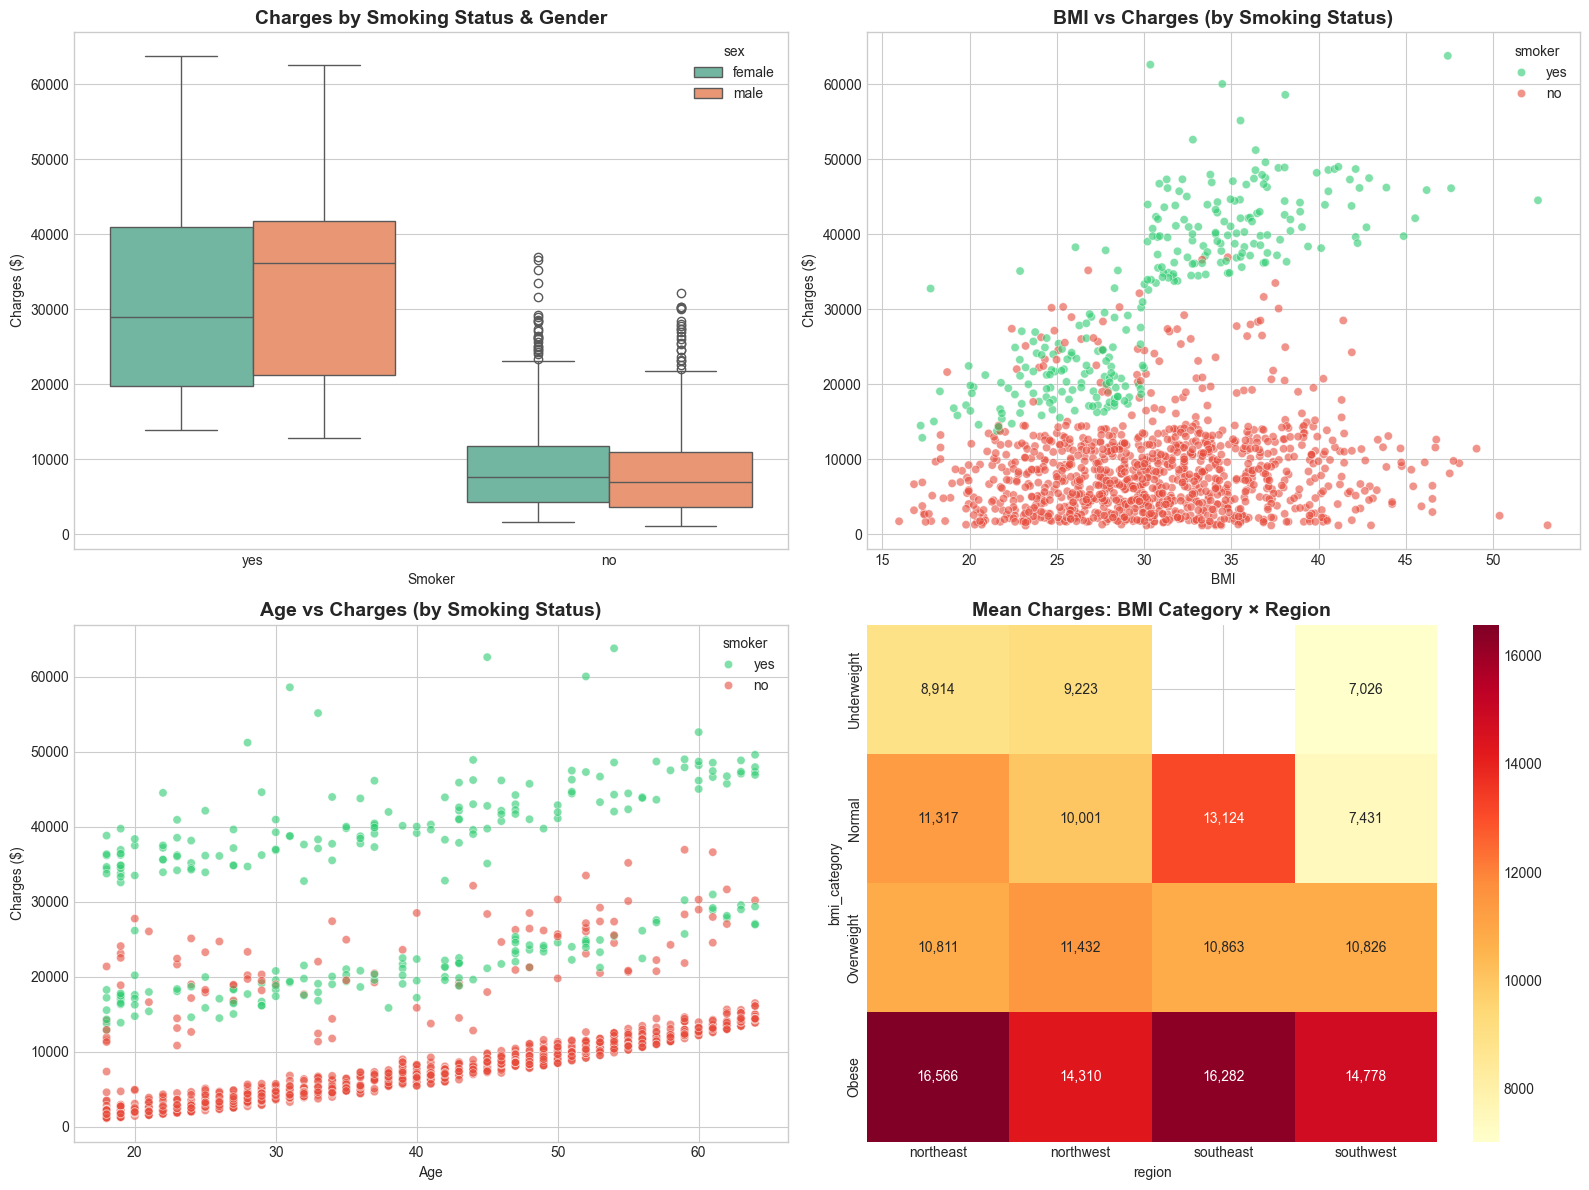


✅ All visualizations saved to reports/figures/


In [18]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Smoker vs Non-Smoker (strongest effect)
sns.boxplot(data=df, x='smoker', y='charges', hue='sex', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Charges by Smoking Status & Gender', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Smoker')
axes[0, 0].set_ylabel('Charges ($)')

# 2. BMI vs Charges with Smoker color
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', ax=axes[0, 1], palette=['#2ecc71', '#e74c3c'], alpha=0.6)
axes[0, 1].set_title('BMI vs Charges (by Smoking Status)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Charges ($)')

# 3. Age vs Charges with Smoker color
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', ax=axes[1, 0], palette=['#2ecc71', '#e74c3c'], alpha=0.6)
axes[1, 0].set_title('Age vs Charges (by Smoking Status)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Charges ($)')

# 4. Region and BMI heatmap
pivot = df.pivot_table(values='charges', index='bmi_category', columns='region', aggfunc='mean')
pivot = pivot.reindex(['Underweight', 'Normal', 'Overweight', 'Obese'])
sns.heatmap(pivot, annot=True, fmt=',.0f', cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Mean Charges: BMI Category × Region', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/hypothesis_testing_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ All visualizations saved to reports/figures/")